# Access this notebook on kaggle at <a href='https://www.kaggle.com/code/sadguava/semseg-tests'>this link</a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from PIL import Image
from tqdm import tqdm

In [3]:
import os
import cv2
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import keras
from keras import layers
from keras.models import Model
#from keras.optimizers import Adam
# from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16

In [5]:
import tensorflow as tf

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
from collections import namedtuple
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      19 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      19 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      19 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      19 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      19 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      19 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      19 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      19 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      19 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      19 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [8]:
mapping_9 = { 
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 1,
    7: 1,
    8: 2,
    9: 0,
    10: 0,
    11: 3,
    12: 3,
    13: 3,
    14: 0,
    15: 0,
    16: 0,
    17: 4,
    18: 0,
    19: 4,
    20: 4,        
    21: 5,
    22: 5,
    23: 6,
    24: 7,
    25: 7,
    26: 8,
    27: 8,
    28: 8,
    29: 0,
    30: 0,
    31: 8,
    32: 8,
    33: 8,
    34: 0
}
    
mapping_9_to_id={
    0: 0,
    1: 7,
    2: 8,
    3: 11,
    4: 17,
    5: 21,
    6: 23,
    7: 24,
    8: 26
}



In [9]:
width, height = 128, 128
IMAGE_SIZE = [width, height]
classes = 9
batch_size = 16
id2color = { label.id : np.asarray(label.color) for label in labels }


In [10]:
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array
    
    return image, mask
def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    
    return closest_category
def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_9:
        label_mask[mask == k] = mapping_9[k]
    return label_mask

In [11]:
# SPLIT VAL DATA INTO VAL AND TEST

train_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
val_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'

train_folder = '/kaggle/working/cityscapes-image-pairs/cityscapes_data/train/'
val_folder = '/kaggle/working/cityscapes-image-pairs/cityscapes_data/val/'
test_folder = '/kaggle/working/cityscapes-image-pairs/cityscapes_data/test/'
# os.makedirs(train_folder); os.makedirs(val_folder); 
os.makedirs(test_folder)

shutil.copytree(train_filepath, train_folder, copy_function = shutil.copy)
shutil.copytree(val_filepath, val_folder, copy_function = shutil.copy)

files = os.listdir(val_folder)
random_files = random.sample(files, 50)
for f in random_files:
  shutil.move(val_folder + f, test_folder + f)

In [12]:
# Store the images, the masks, and the encoded masks
train_images = [] 
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []
test_images = []
test_masks = []
test_masks_enc = []

In [13]:
def build_data(folder, images, masks, masks_enc):
    for file in tqdm(os.listdir(folder)):
        image, mask = image_mask_split(folder + file, IMAGE_SIZE)
        images.append(image)
        masks.append(mask)
        masks_enc.append(encode_labels(find_closest_labels_vectorized(mask, id2color)))
    return images, masks, masks_enc

In [14]:
print('building training dataset: ')
train_images, train_masks, train_masks_enc = build_data(train_folder, train_images, train_masks, train_masks_enc)
print('building validation dataset: ')
val_images, val_masks, val_masks_enc = build_data(val_folder, val_images, val_masks, val_masks_enc)
print('building testing dataset: ')
test_images, test_masks, test_masks_enc = build_data(test_folder, test_images, test_masks, test_masks_enc)

building training dataset: 


100%|██████████| 2975/2975 [02:42<00:00, 18.26it/s]


building validation dataset: 


100%|██████████| 450/450 [00:24<00:00, 18.38it/s]


building testing dataset: 


100%|██████████| 50/50 [00:02<00:00, 19.04it/s]


In [15]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

2023-01-11 09:12:43.671485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 09:12:43.672492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 09:12:43.874920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 09:12:43.875806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 09:12:43.876587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

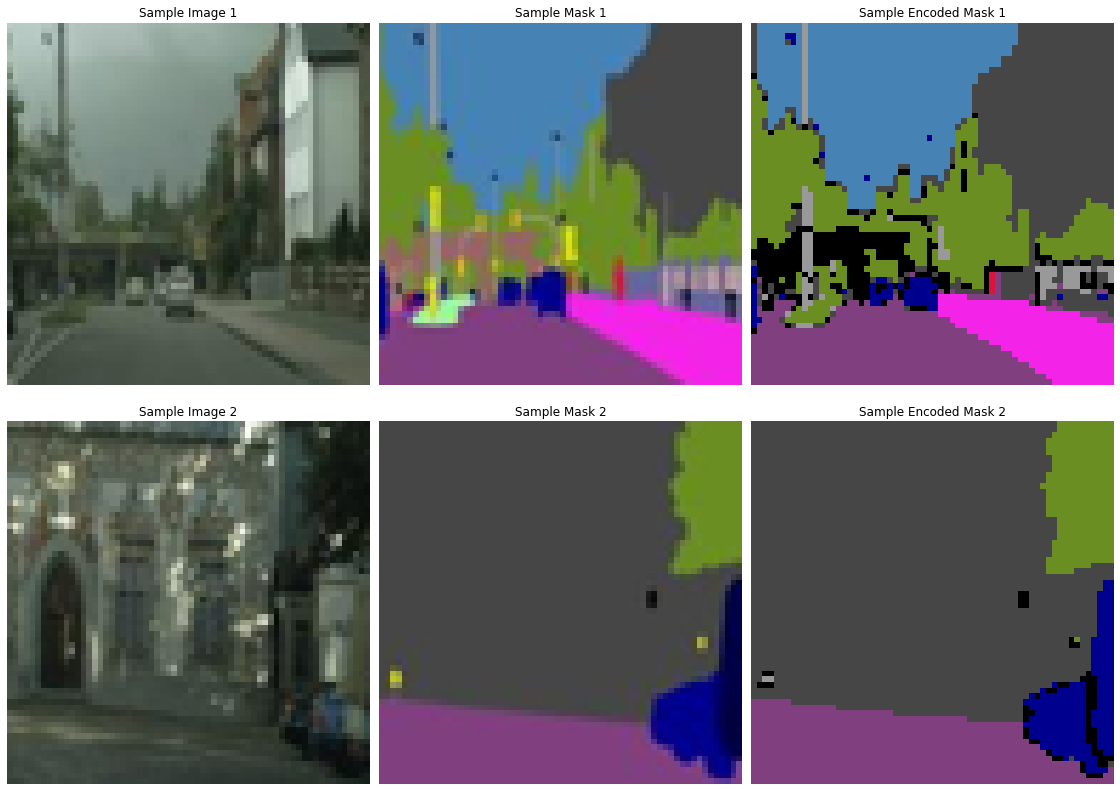

In [16]:
crop_width = int(width/2); crop_height = int(height/2)
seed = (1,2)

plt.figure(figsize=[20, 14])

for i in range(2):
    img = tf.image.stateless_random_crop(
                value = val_images[i], 
                size = (crop_width, crop_height, 3), 
                seed = seed
            ).numpy()
    msk = tf.image.stateless_random_crop(
                value = val_masks[i],
                size = (crop_width, crop_height, 3), 
                seed = seed
            ).numpy()
    enc = tf.image.stateless_random_crop(
                value = val_masks_enc[i],
                size = (crop_width, crop_height), 
                seed = seed
            ).numpy()
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[mapping_9_to_id[enc[row, col]]]
            tmp = tmp.astype('uint8')
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

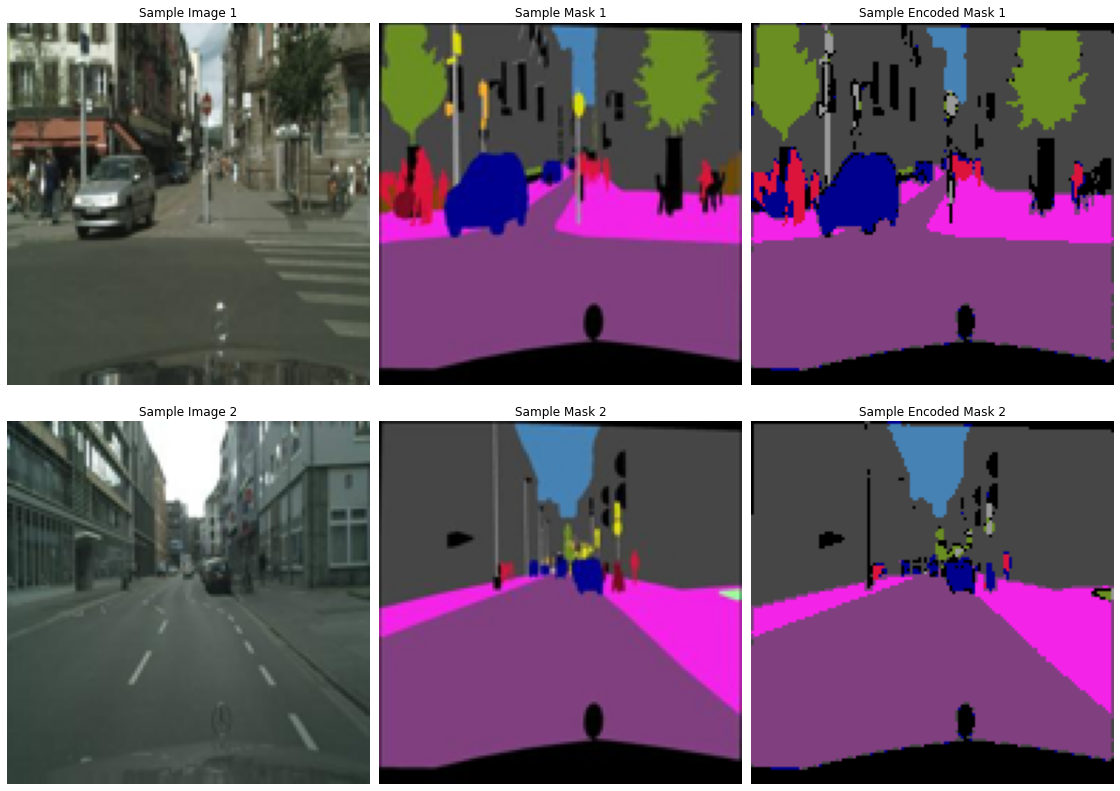

In [17]:
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[mapping_9_to_id[enc[row, col]]]
            tmp = tmp.astype('uint8')
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [18]:
del train_masks, val_masks

In [19]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [20]:
def bottle_neck(inputs):
  res = inputs
  x = layers.Conv2D(64,kernel_size=1,padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)

  x2 = layers.Conv2D(64,kernel_size=3,padding='same')(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  x3 = layers.Conv2D(128,kernel_size=1,padding='same')(x2)
  x3 = layers.BatchNormalization()(x3)
  x3 = tf.keras.activations.relu(x3)
  return x3 

def basic_block(inputs,num_channels,stride,padding):
  res = inputs

  x = layers.Conv2D(num_channels,kernel_size=3,strides=stride,padding = padding)(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  
  x2 = layers.Conv2D(num_channels,kernel_size=3,strides=1,padding = padding)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  return x2

In [21]:
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_12_expand_relu'
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

base_model.summary()

  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368
9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 

In [29]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(width,height, 3))
    
    skips = down_stack(inputs)
    skip1=layers.UpSampling2D((2,2))(skips[0])
    
    skip21=skips[0]
    skip22=layers.UpSampling2D((2,2))(skips[1])
    
    skip31=skips[1]
    skip32=layers.UpSampling2D((2,2))(skips[2])
    skip33=layers.UpSampling2D((4,4))(skips[3])
    skip3=tf.keras.layers.Concatenate(axis=-1)([skip31,skip32 , skip33])

    
    

    x1 = bottle_neck(skip1)
    x1 = bottle_neck(x1)
    print("x1 = " , x1.shape)

    x21 = basic_block(x1,x1.shape[3],1,'same')
    x21 = basic_block(x21,x21.shape[3],1,'same')
    print("x21 = ",x21.shape)

    x22 = basic_block(x1,x1.shape[3]*2,2,'same')
    x22=tf.keras.layers.Concatenate(axis=-1)([x22,skip21 , skip22])
    x22 = basic_block(x22,x1.shape[3]*2,1,'same')
    print("x22 = ",x22.shape)


    x31 = layers.UpSampling2D((2,2))(x22)
    x31 = layers.Conv2D(x21.shape[3], (1,1) , strides =1 , padding = "same")(x31)
    x31 = tf.keras.layers.Add()([x21,x31])
    print("x31 = " , x31.shape)
    x31 = basic_block(x31,x31.shape[3],1,'same')
    print("x31 = " , x31.shape)
    x31 = basic_block(x31,x31.shape[3],1,'same')
    print("x31 = " , x31.shape)

    x32_1 = basic_block(x21 , x21.shape[3]*2 , 2 , 'same')
    x32_2= layers.Conv2D(x22.shape[3], (1,1) , strides =1 , padding = "same")(x22)
    x32 =tf.keras.layers.Add()([x32_1,x32_2])
    print("x32 = " , x32.shape)
    x32 = basic_block(x32,x32.shape[3],1,'same')
    print("x32 = " , x32.shape)
    x32 = basic_block(x32,x32.shape[3],1,'same')
    print("x32 = " , x32.shape)

    x33_1 = basic_block(x21 , x21.shape[3]*4 , 4 , 'same')
    x33_2 = basic_block(x22 , x22.shape[3]*2 , 2 , 'same')
    x33 = tf.keras.layers.Add()([x33_1,x33_2])
    x33= tf.keras.layers.Concatenate(axis=-1)([x33 , skip3])

    print("x33 = ", x33.shape)
    x33 = basic_block(x33,x22.shape[3]*2,1,'same')
    print("x33 = ", x33.shape)
    x33 = basic_block(x33,x33.shape[3],1,'same')
    print("x33 = ", x33.shape)

    x41_2 =  layers.UpSampling2D((2,2))(x32)
    x41_2 = layers.Conv2D(x31.shape[3], (1,1) , strides =1 , padding = "same")(x41_2)
    x41_3 = layers.UpSampling2D((4,4))(x33)
    x41_3= layers.Conv2D(x31.shape[3], (1,1) , strides =1 , padding = "same")(x41_3)

    output = tf.keras.layers.Concatenate(axis=-1)([x31,x41_2 , x41_3])
    print("output = " , output.shape)
    outputs = tf.keras.layers.Conv2D(classes, 1, activation='softmax')(output) 
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [30]:
model = create_model()
model.summary()

x1 =  (None, 128, 128, 128)
x21 =  (None, 128, 128, 128)
x22 =  (None, 64, 64, 256)
x31 =  (None, 128, 128, 128)
x31 =  (None, 128, 128, 128)
x31 =  (None, 128, 128, 128)
x32 =  (None, 64, 64, 256)
x32 =  (None, 64, 64, 256)
x32 =  (None, 64, 64, 256)
x33 =  (None, 32, 32, 1424)
x33 =  (None, 32, 32, 512)
x33 =  (None, 32, 32, 512)
output =  (None, 128, 128, 384)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 64, 64, 96), 495488      input_3[0][0]                    
__________________________________________________________________________________________________
up_sampling2d_7 (UpSamp

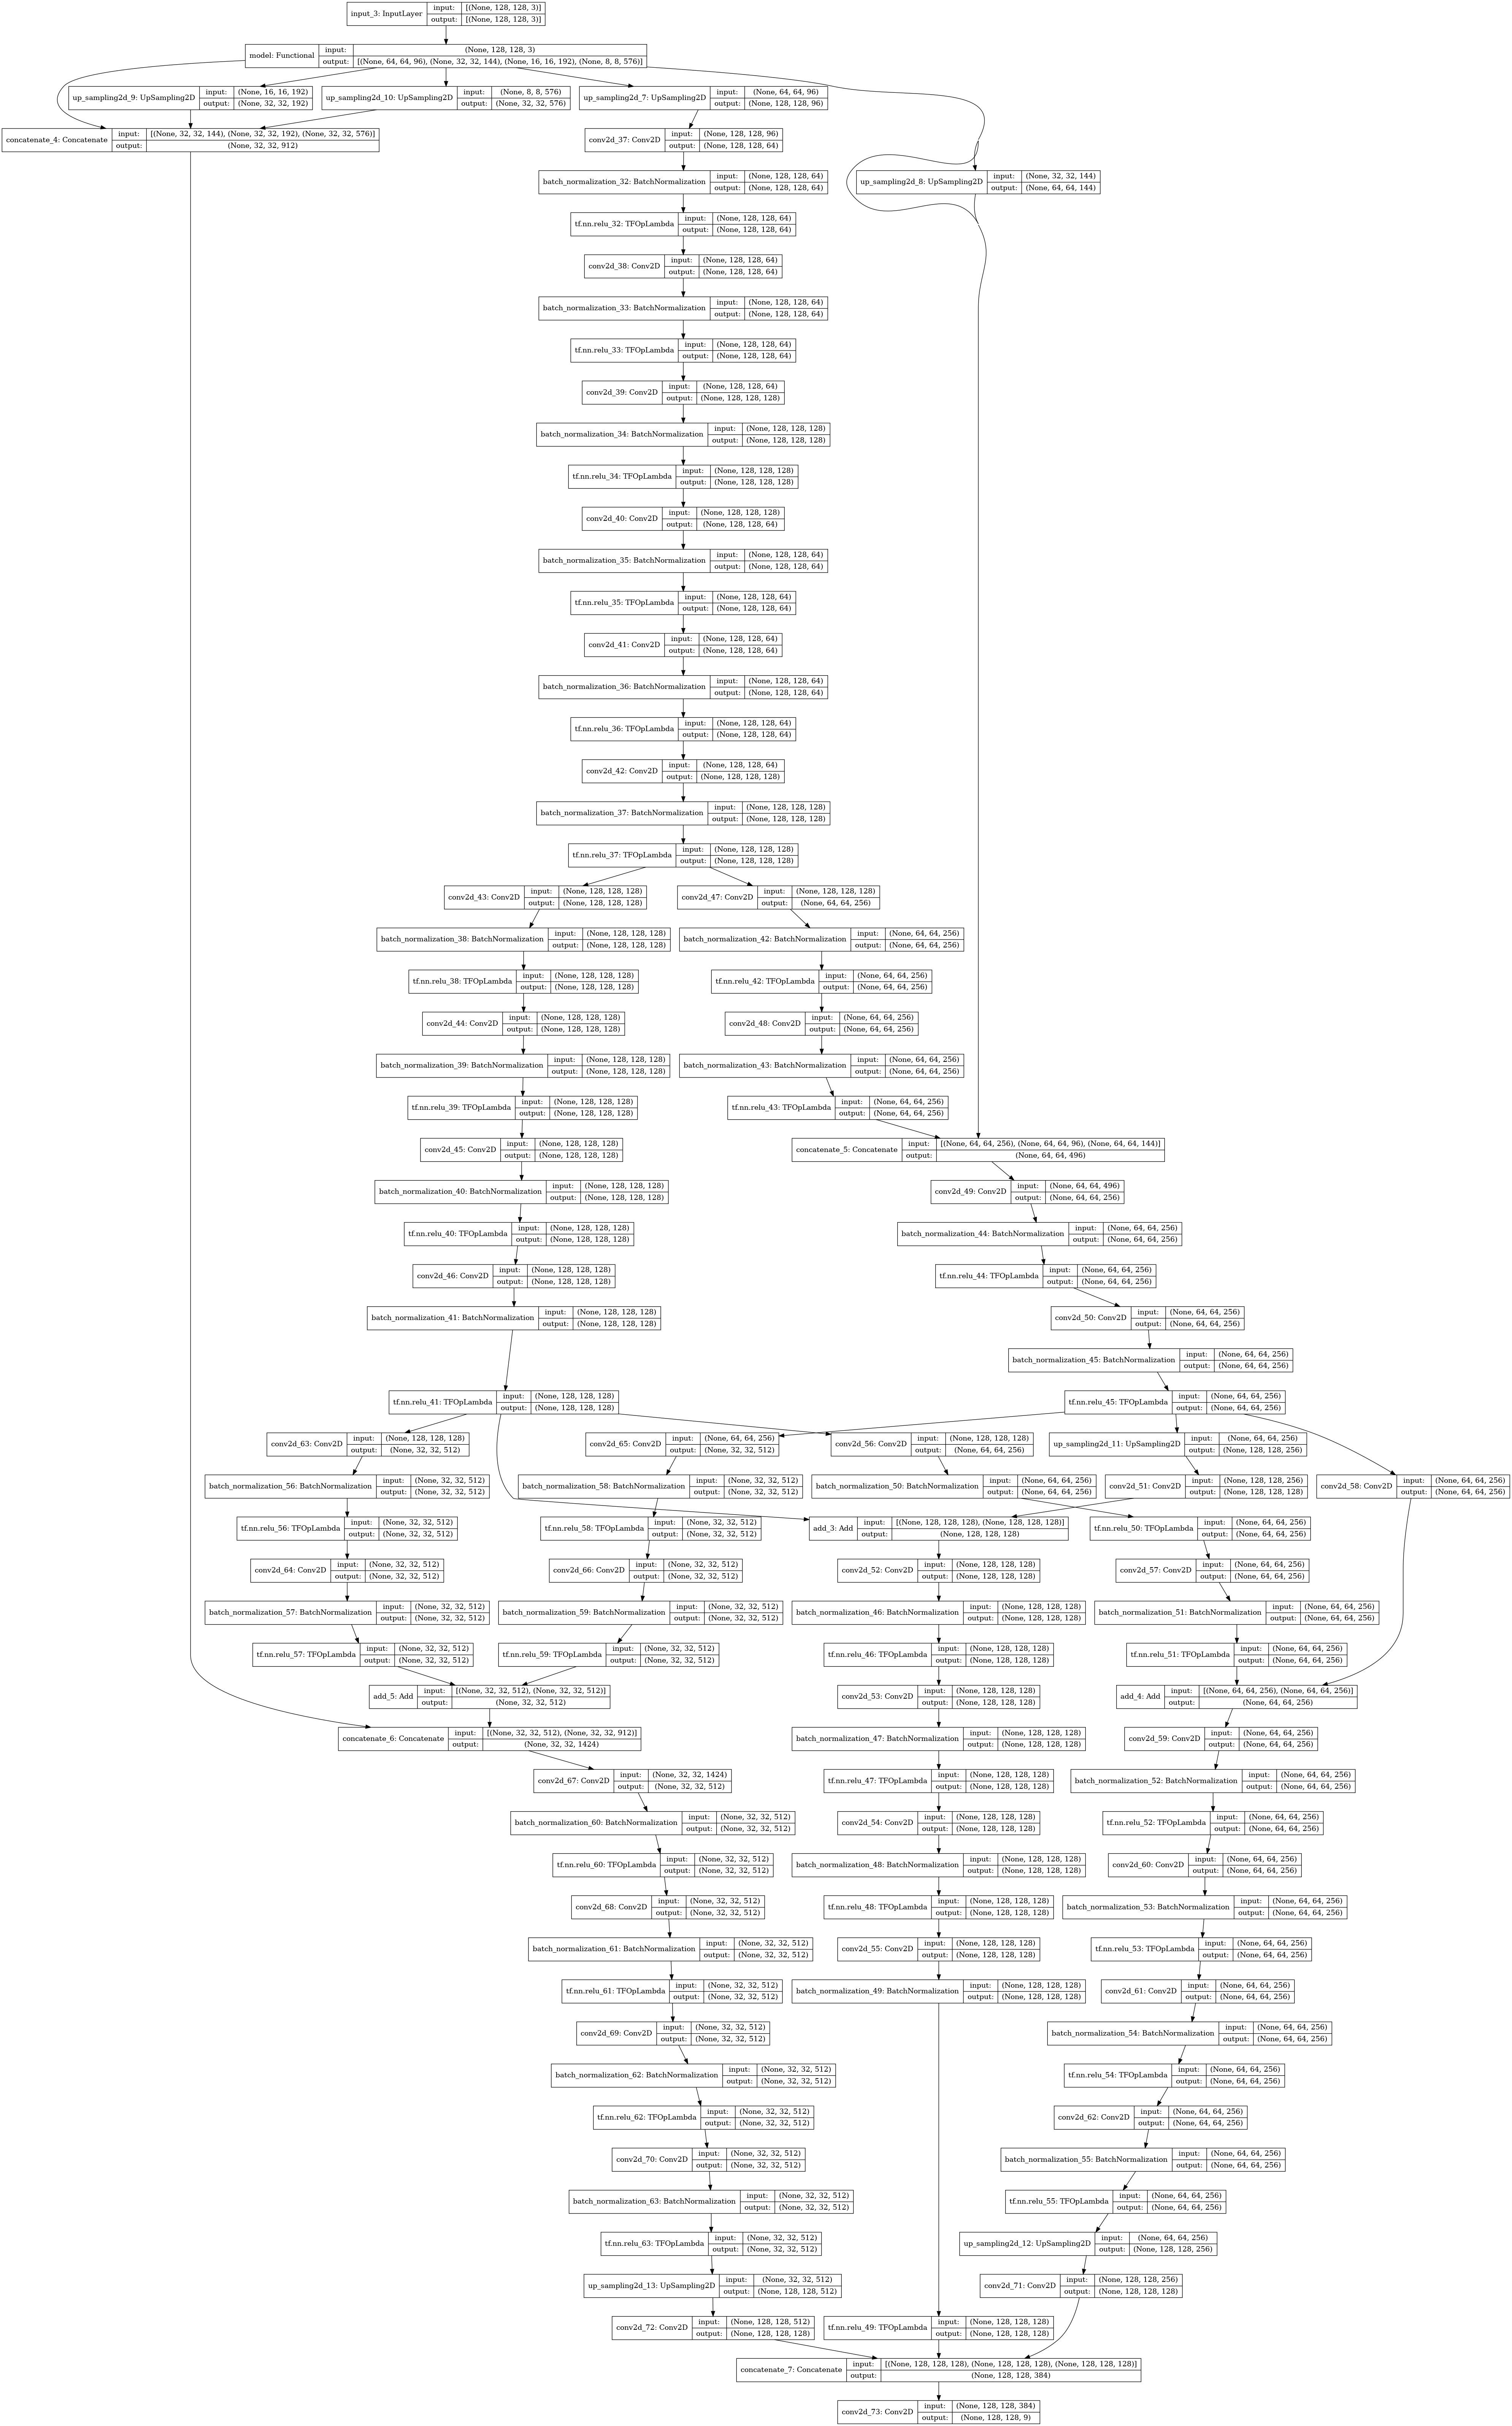

In [31]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [32]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [33]:
import tensorflow.keras.backend as K
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-7, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def dice_coef(self,y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1- tf.divide(nominator, denominator)
        return result

    def call(self,y_true, y_pred, M=classes):
        y_true = tf.one_hot(tf.cast(y_true,tf.int32),M)
        dice = 0
        for index in range(M):
            dice += self.dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return dice
    
loss = DiceLoss()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01        
                                    ,decay=0.005),
    loss=loss,
    metrics = ["accuracy", UpdatedMeanIoU(num_classes=classes, name = "mean_iou")])

In [34]:
MODEL_CHECKPOINT_FILEPATH = '/kaggle/working/cityscapes-Hr-net.ckpt'
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_mean_iou',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou', 
                               patience = 5,
                               restore_best_weights = True, 
                               min_delta = 0.0001,
                               mode='max',
                               verbose=2,
                               baseline=None)
    
callbacks = [model_checkpoint , early_stopping]

In [35]:
history = model.fit(x = train_images,
                    y = train_masks_enc,
                    batch_size = 16,
                    epochs = 80,
                    validation_data = (val_images, val_masks_enc),
                    callbacks = callbacks)

Epoch 1/80
186/186 [==============================] - 243s 1s/step - loss: 5.7555 - accuracy: 0.4325 - mean_iou: 0.2765 - val_loss: 5.8992 - val_accuracy: 0.3793 - val_mean_iou: 0.2333

Epoch 00001: val_mean_iou improved from -inf to 0.23333, saving model to /kaggle/working/cityscapes-Hr-net.ckpt
Epoch 2/80
186/186 [==============================] - 229s 1s/step - loss: 3.8827 - accuracy: 0.5701 - mean_iou: 0.4204 - val_loss: 2.9520 - val_accuracy: 0.7729 - val_mean_iou: 0.5021

Epoch 00002: val_mean_iou improved from 0.23333 to 0.50213, saving model to /kaggle/working/cityscapes-Hr-net.ckpt
Epoch 3/80
186/186 [==============================] - 237s 1s/step - loss: 2.4913 - accuracy: 0.8038 - mean_iou: 0.5593 - val_loss: 2.6179 - val_accuracy: 0.8008 - val_mean_iou: 0.5398

Epoch 00003: val_mean_iou improved from 0.50213 to 0.53975, saving model to /kaggle/working/cityscapes-Hr-net.ckpt
Epoch 4/80
186/186 [==============================] - 229s 1s/step - loss: 2.3016 - accuracy: 0.8189

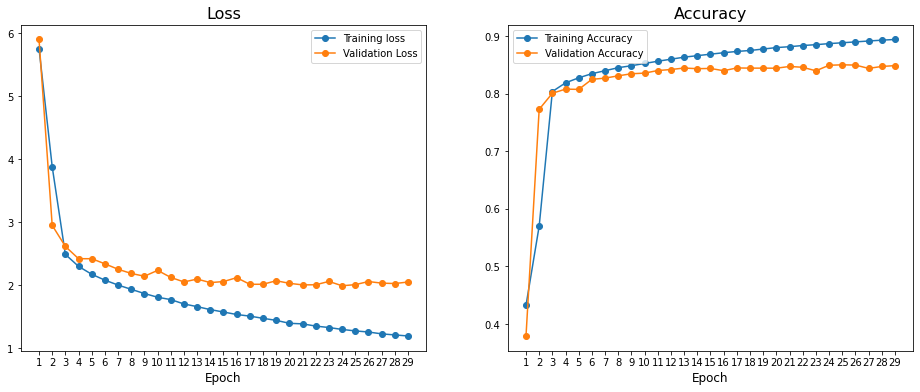

In [36]:
EPOCHS = len(history.history['loss'])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, EPOCHS + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, EPOCHS + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

In [37]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH) # load the best model weights

val_loss, val_accuracy,val_mIoU = model.evaluate(x = val_images, y = val_masks_enc) # re-evaluate on the validation data

print('The model had an accuracy score of '+str(format(round(100*val_accuracy, 2))) + ' and a mIoU of '+ str(format(round(100*val_mIoU, 2))))

15/15 [==============================] - 17s 740ms/step - loss: 1.9605 - accuracy: 0.8494 - mean_iou: 0.6282
The model had an accuracy score of 84.94 and a mIoU of 62.82


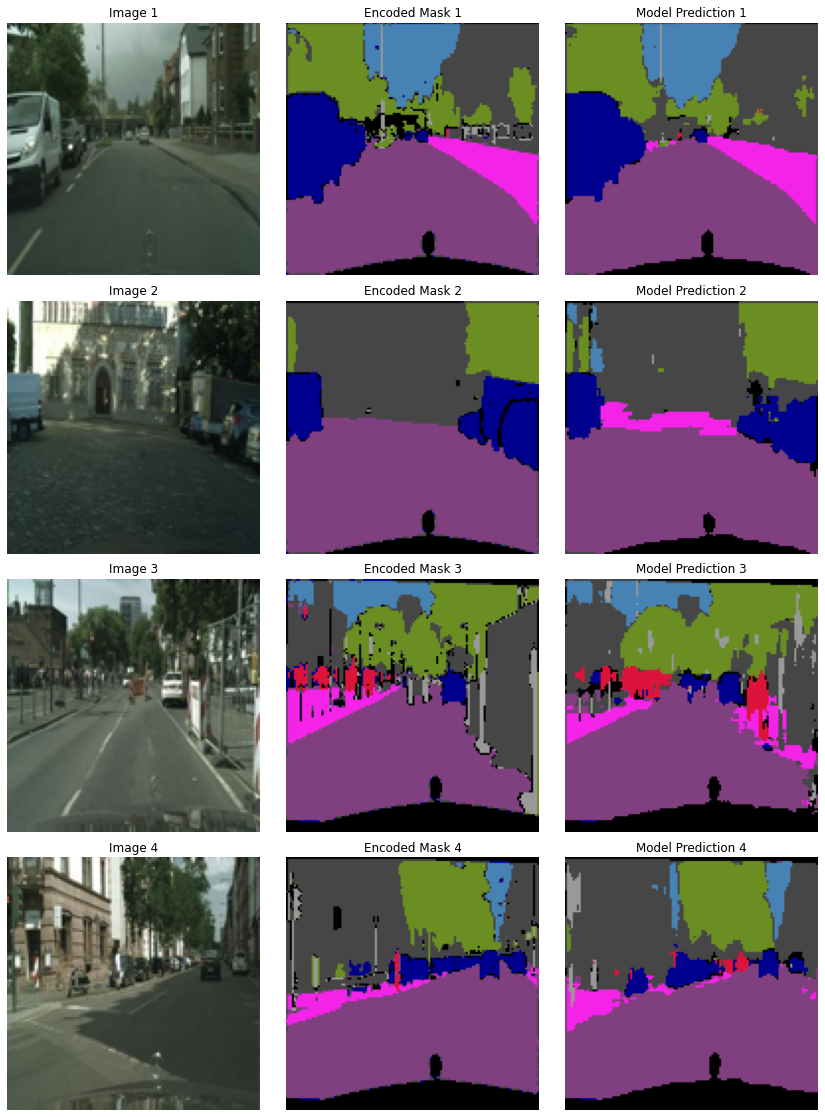

In [40]:
plt.figure(figsize=[15, 20])
IMAGE_SHAPE = IMAGE_SIZE + [3,]

for i in range(4):    
    img = val_images[i]
    enc = val_masks_enc[i]
    
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))
    
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[mapping_9_to_id[enc[row, col]]]
            tmp1 = tmp1.astype('uint8')
                     
            tmp2[row, col, :] = id2color[mapping_9_to_id[pred[row, col]]]
            tmp2 = tmp2.astype('uint8')
            
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [39]:
model.save("9c_highLoss.h5")